In [128]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Missing Values:
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

Number of Duplicate Rows: 0


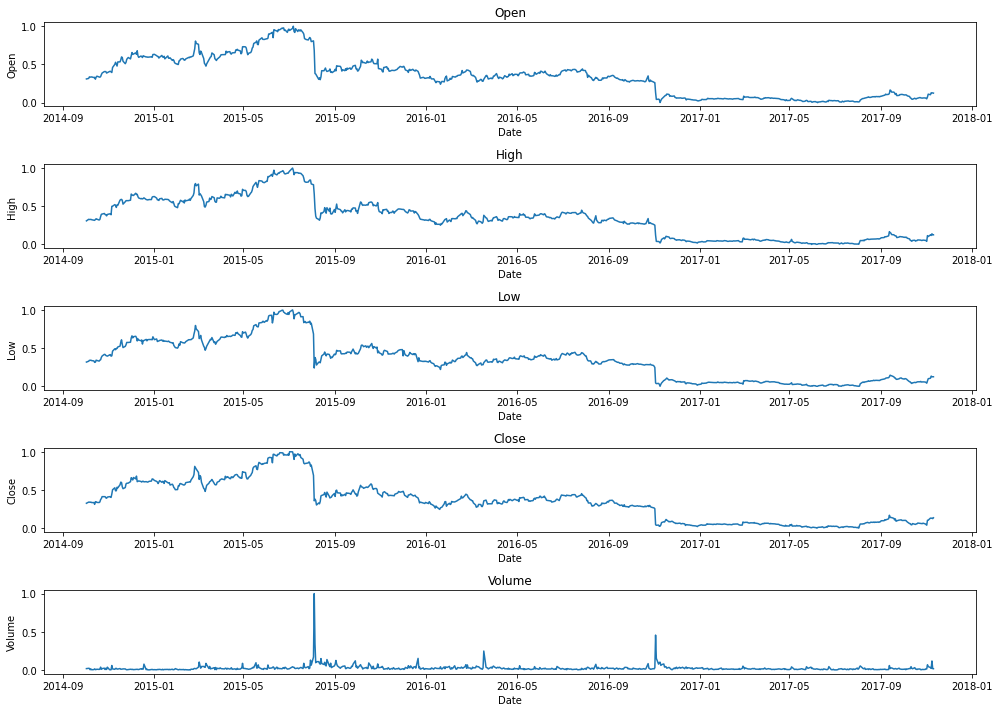

In [129]:
# Load the CSV file
file_path = 'aac.us.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)
df=df.drop(df['OpenInt'])
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

missing_values = df.isnull().sum()

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()

print("Missing Values:\n", missing_values)
print("\nNumber of Duplicate Rows:", duplicate_rows)
# Plot each feature against 'Date'
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
#df['Volume'] = scaler.fit_transform(df[['Volume']])

features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(14, 10))

for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i + 1)
    plt.plot(df['Date'], df[feature])
    plt.title(feature)
    plt.xlabel('Date')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()
df=df.drop(columns=['Date','OpenInt'])

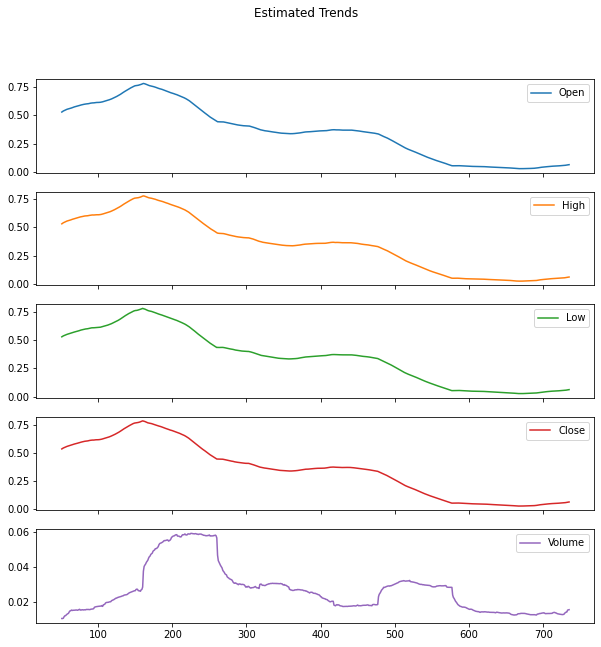

In [18]:
# Estimate the trend for each column using a rolling mean
rolling_window = 100
trend_estimate = df.rolling(window=rolling_window, center=True).mean()

# Plot the trend estimates
trend_estimate.plot(subplots=True, figsize=(10, 10), title='Estimated Trends')
plt.show()


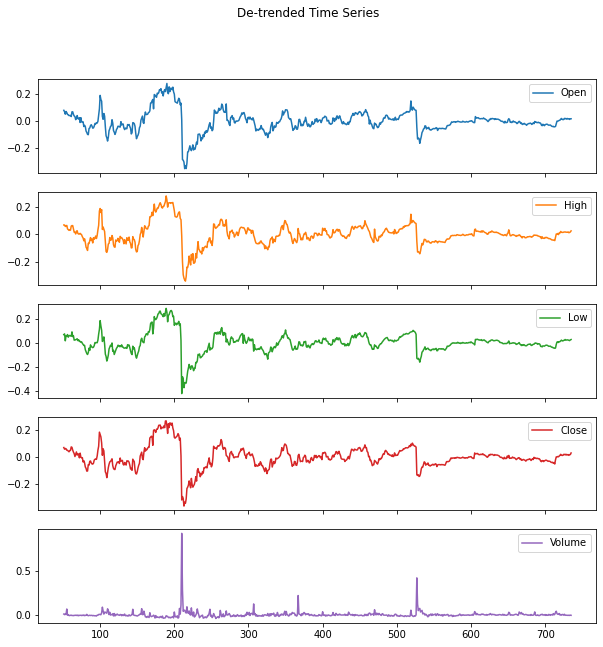

In [130]:
detrended_data = df - trend_estimate

# Drop NaN values created by the rolling window
detrended_data = detrended_data.dropna()

# Plot the de-trended data
detrended_data.plot(subplots=True, figsize=(10, 10), title='De-trended Time Series')
plt.show()

In [156]:
def create_sequences(data, seq_length, n_steps):
    X, y = [], []
    for i in range(len(data) - seq_length - n_steps + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + n_steps])
    return np.array(X), np.array(y)




# Create sequences of data for LSTM
X, y = create_sequences(detrended_data, 50,1)
train_size2 = int(len(X) * 0.8) 

X_train, X_val = X[:train_size2], X[train_size2:]
y_train, y_val = y[:train_size2], y[train_size2:]


In [134]:
model = Sequential([
    LSTM(units=50, activation='relu', return_sequences=True, input_shape=(50, 5)),
    Dropout(0.2),
    LSTM(units=100,return_sequences=True, activation='relu'),
    Dropout(0.2),
    LSTM(units=100,return_sequences=True, activation='relu'),
    Dropout(0.2),
    LSTM(units=100, activation='relu'),
    Dropout(0.2),
    Dense(units=5),
    Reshape((1, 5))
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
16/16 [==============================] - 10s 186ms/step - loss: 0.0070 - val_loss: 3.0922e-04
Epoch 2/100
16/16 [==============================] - 2s 130ms/step - loss: 0.0051 - val_loss: 6.8996e-04
Epoch 3/100
16/16 [==============================] - 2s 143ms/step - loss: 0.0055 - val_loss: 8.0033e-04
Epoch 4/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0040 - val_loss: 2.1635e-04
Epoch 5/100
16/16 [==============================] - 2s 134ms/step - loss: 0.0029 - val_loss: 4.3649e-04
Epoch 6/100
16/16 [==============================] - 2s 135ms/step - loss: 0.0027 - val_loss: 4.1891e-04
Epoch 7/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0023 - val_loss: 1.3063e-04
Epoch 8/100
16/16 [==============================] - 2s 136ms/step - loss: 0.0022 - val_loss: 1.8543e-04
Epoch 9/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0022 - val_loss: 4.1375e-04
Epoch 10/100
16/16 [==============================] - 

4/4 [==============================] - 0s 27ms/step


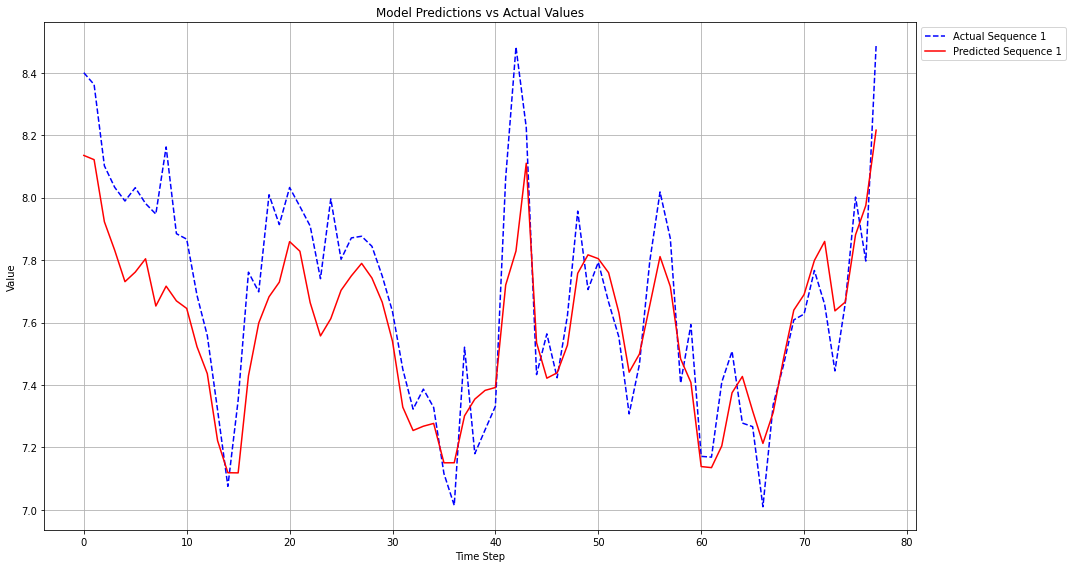

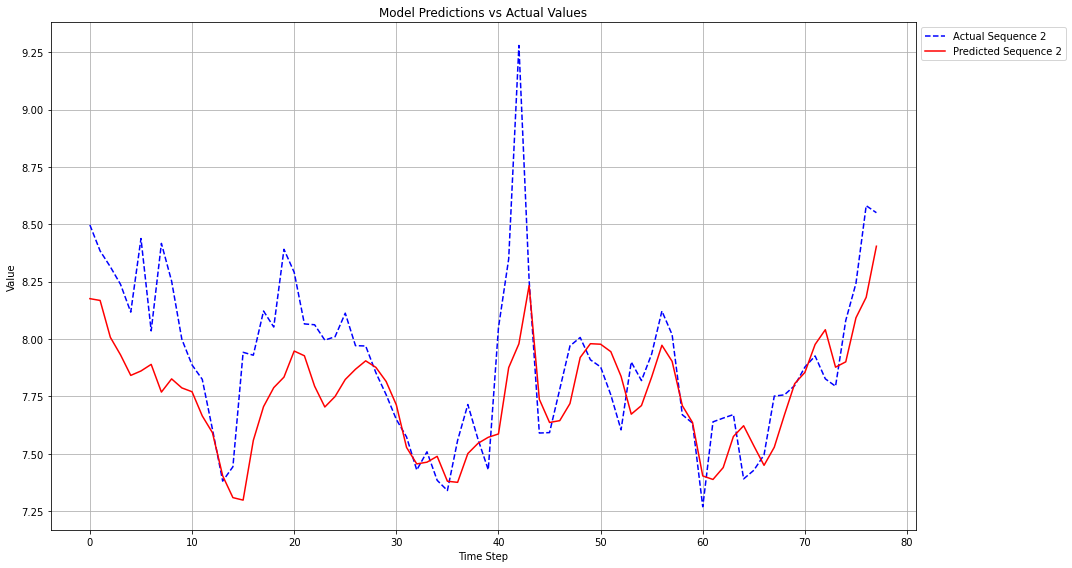

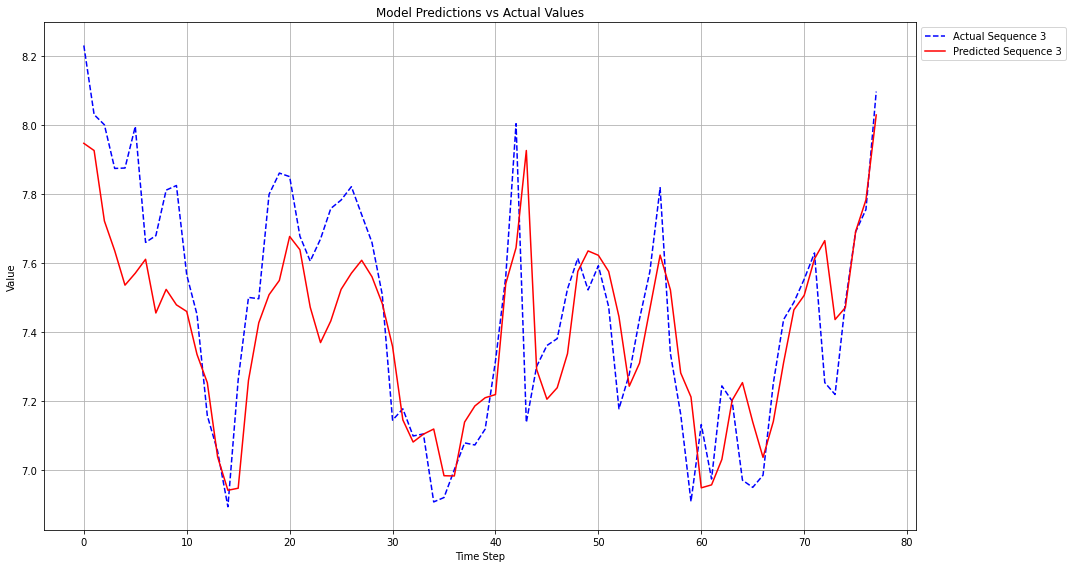

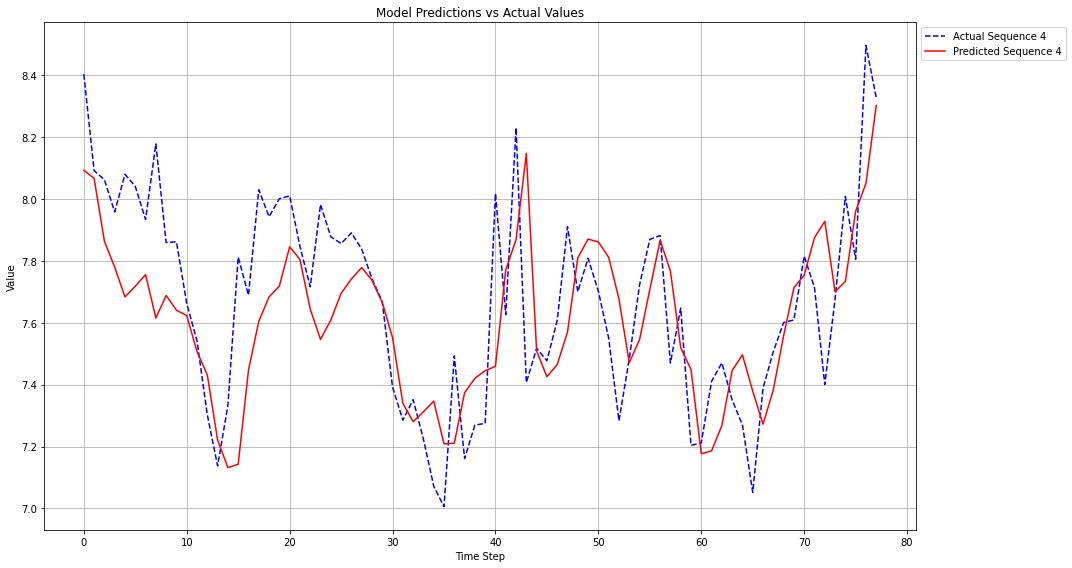

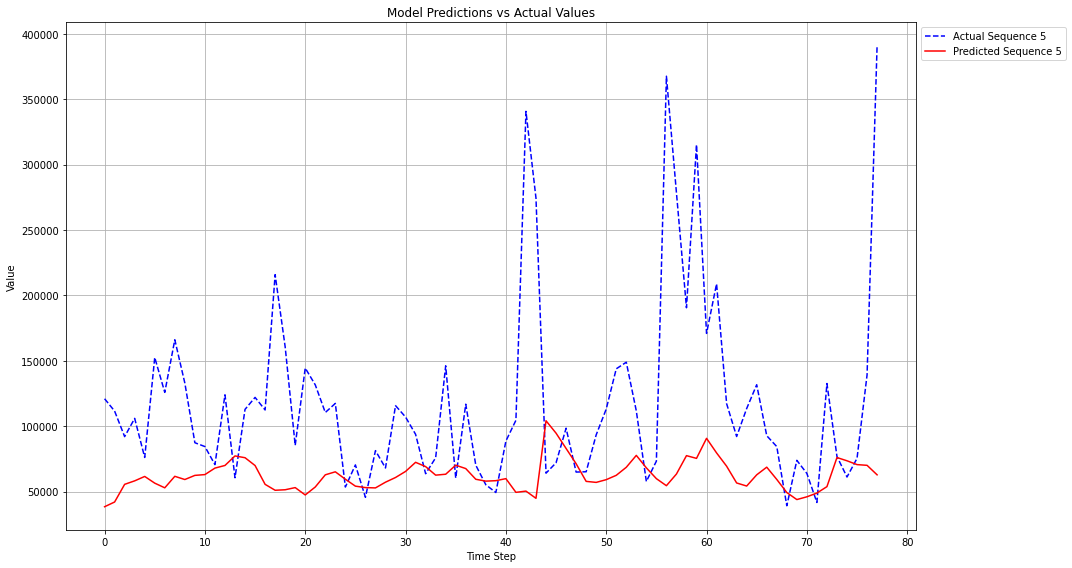

In [149]:
predictions = model.predict(X_val).reshape(-1,5)
predictions=predictions.reshape(-1,5) + trend_estimate[-127:]
predictions=scaler.inverse_transform(predictions)
y_val=y_val.reshape(-1,5)  + trend_estimate[-127:]
y_val=scaler.inverse_transform(y_val)
for i in range(5):
    plt.figure(figsize=(15, 8))
        # Plot actual values with '--' linestyle
    plt.plot( y_val[:,i], label=f'Actual Sequence {i+1}', color='blue', linestyle='--')
        
        # Plot predicted values
    plt.plot(predictions[:,i], label=f'Predicted Sequence {i+1}', color='red')
    plt.title('Model Predictions vs Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

    

In [166]:

X_train, X_val = X[:train_size2], X[train_size2:]
y_train, y_val = y[:train_size2], y[train_size2:]


In [167]:
model2 = Sequential()
model2.add(LSTM(100, activation='relu', input_shape=(50, 5)))
model2.add(Dropout(0.22))
model2.add(RepeatVector(1))
model2.add(LSTM(100, activation='relu', return_sequences=True))
model2.add(Dropout(0.22))
model2.add(TimeDistributed(Dense(5)))
model2.compile(optimizer='adam', loss='mse')
model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val,y_val), verbose=1)

Epoch 1/50
16/16 [==============================] - 4s 49ms/step - loss: 0.0069 - val_loss: 2.2454e-04
Epoch 2/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 2.2337e-04
Epoch 3/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 1.1973e-04
Epoch 4/50
16/16 [==============================] - 0s 28ms/step - loss: 0.0021 - val_loss: 9.2431e-05
Epoch 5/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 9.3051e-05
Epoch 6/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 1.0112e-04
Epoch 7/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0019 - val_loss: 7.7225e-05
Epoch 8/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 8.0192e-05
Epoch 9/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 7.0812e-05
Epoch 10/50
16/16 [==============================] - 0s 27ms/step - loss:

4/4 [==============================] - 0s 9ms/step


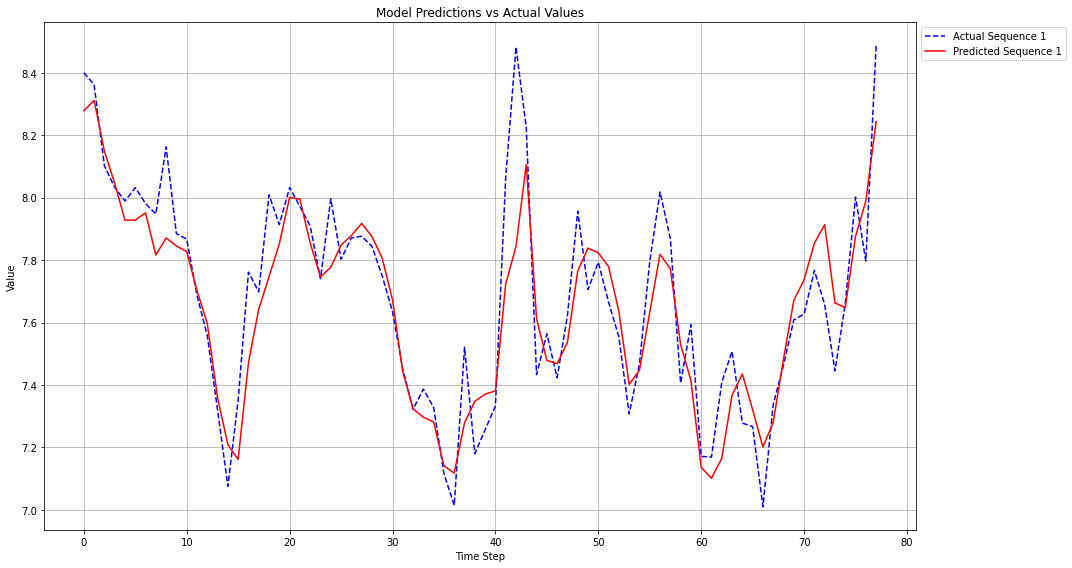

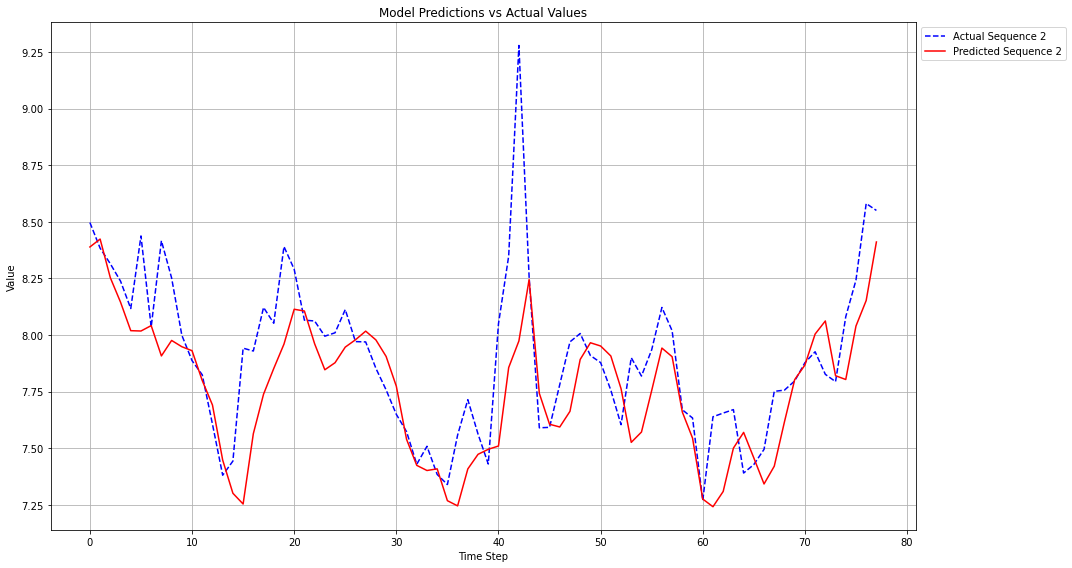

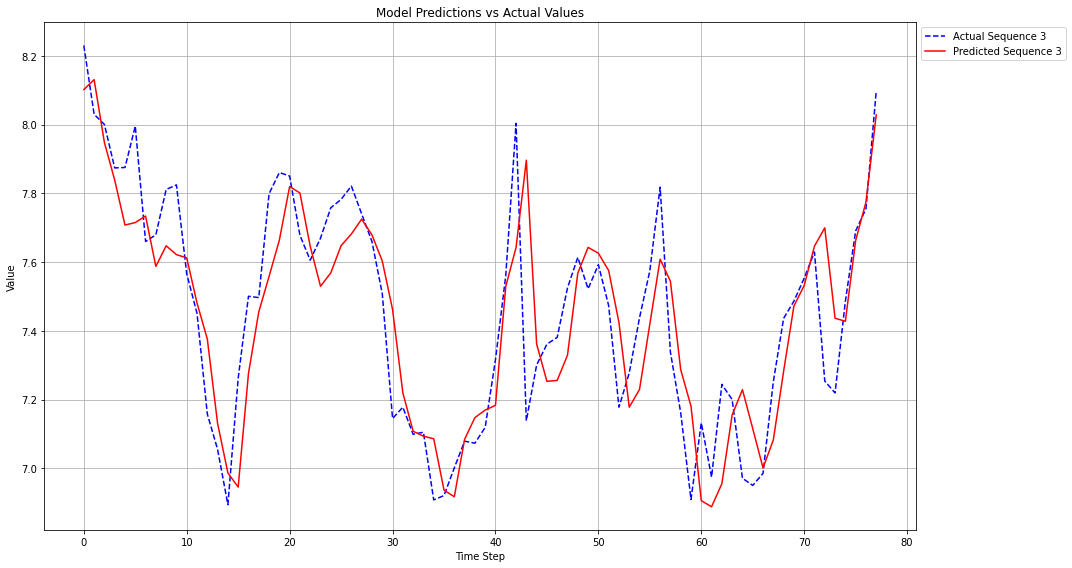

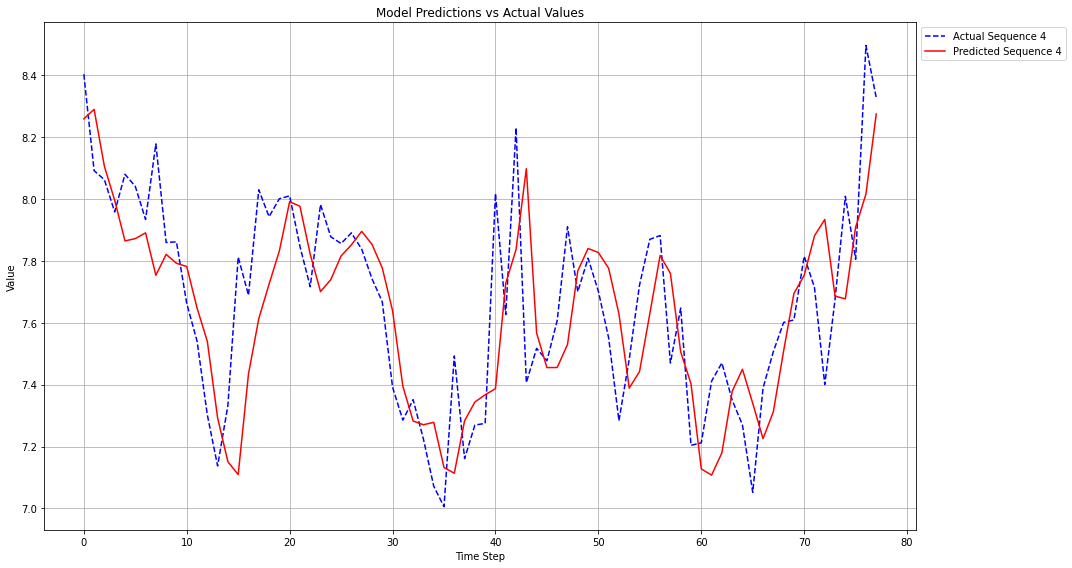

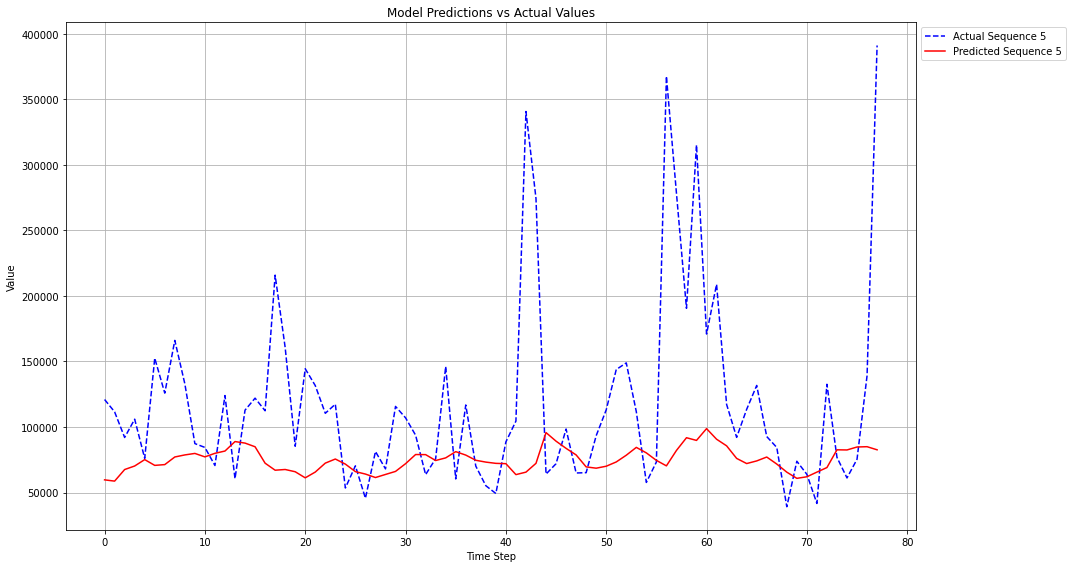

In [168]:
predictions = model2.predict(X_val).reshape(-1,5)
predictions=predictions.reshape(-1,5) + trend_estimate[-127:]
predictions=scaler.inverse_transform(predictions)
y_val=y_val.reshape(-1,5)  + trend_estimate[-127:]
y_val=scaler.inverse_transform(y_val)
for i in range(5):
    plt.figure(figsize=(15, 8))
        # Plot actual values with '--' linestyle
    plt.plot( y_val[:,i], label=f'Actual Sequence {i+1}', color='blue', linestyle='--')
        
        # Plot predicted values
    plt.plot(predictions[:,i], label=f'Predicted Sequence {i+1}', color='red')
    plt.title('Model Predictions vs Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    